# G(PO)MDP

This notebook is inspired to the Stable Baselines3 tutorial available at [https://github.com/araffin/rl-tutorial-jnrr19](https://github.com/araffin/rl-tutorial-jnrr19).


## Introduction

In this notebook, we will learn how to build a customized algorithms with **Gymnasium**.

### Links

Gymnasium Github: [https://github.com/Farama-Foundation/Gymnasium](https://github.com/Farama-Foundation/Gymnasium)

Gymnasium Documentation: [https://gymnasium.farama.org/index.html](https://gymnasium.farama.org/index.html#)

Stable Baselines 3 Github:[https://github.com/DLR-RM/stable-baselines3](https://github.com/DLR-RM/stable-baselines3)

Stable Baseline 3 Documentation: [https://stable-baselines3.readthedocs.io/en/master/](https://stable-baselines3.readthedocs.io/en/master/)

## Install Gymnasium and Stable Baselines3 Using Pip

G(PO)MDP algorithm is policy-basced policy gradient, improvement of REINFORCE by removing some terms

In [1]:
!pip install gymnasium
!pip install renderlab  #For rendering
!pip install stable-baselines3[extra]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.7/181.7 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 30.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 51.1 MB/s eta 0:00:00
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446660 sha256=22534007a76511a4c23866937e24504af0d6e5d77c56fd251539ce5c3b7ad619
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully built AutoROM.accept-rom-license


In [2]:
import numpy as np

from typing import Optional

import gymnasium as gym
from gymnasium.envs.registration import register
from gymnasium.envs.classic_control.continuous_mountain_car import Continuous_MountainCarEnv
import renderlab
import stable_baselines3

import matplotlib.pyplot as plt

print(gym.__version__)
print(stable_baselines3.__version__)

  np.bool8: (False, True),

  from scipy.ndimage.filters import sobel



0.29.1
2.2.1


In [3]:
def evaluate(env, policy, gamma=1., num_episodes=100):
    """
    Evaluate a RL agent
    :param env: (Env object) the Gym environment
    :param policy: (BasePolicy object) the policy in stable_baselines3
    :param gamma: (float) the discount factor
    :param num_episodes: (int) number of episodes to evaluate it
    :return: (float) Mean reward for the last num_episodes
    """
    all_episode_rewards = []
    for i in range(num_episodes): # iterate over the episodes
        episode_rewards = []
        done = False
        discounter = 1.
        obs, _ = env.reset()
        while not done: # iterate over the steps until termination
            action, _ = policy.predict(obs)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode_rewards.append(reward * discounter) # compute discounted reward
            discounter *= gamma

        all_episode_rewards.append(sum(episode_rewards))

    mean_episode_reward = np.mean(all_episode_rewards)
    std_episode_reward = np.std(all_episode_rewards) / np.sqrt(num_episodes - 1)
    print("Mean reward:", mean_episode_reward,
          "Std reward:", std_episode_reward,
          "Num episodes:", num_episodes)

    return mean_episode_reward, std_episode_reward

  and should_run_async(code)



## Plotting

A helper function to plot the learning curves.

In [4]:
def plot_results(results):
    plt.figure()

    _mean = []
    _std = []
    for m, s in results:
        _mean.append(m)
        _std.append(s)

    _mean = np.array(_mean)
    _std = np.array(_std)

    ts = np.arange(len(_mean))
    plt.plot(ts, _mean, label='G(PO)MDP')
    plt.fill_between(ts, _mean-_std, _mean+_std, alpha=.2)

    plt.xlabel('Trajectories')
    plt.ylabel('Average return')
    plt.legend(loc='lower right')

    plt.show()

## G(PO)MDP

![ss](https://github.com/albertometelli/rl-phd-2024/blob/main/gpomdp.png?raw=1)

**References**

Baxter, Jonathan, and Peter L. Bartlett. "Infinite-horizon policy-gradient estimation." Journal of Artificial Intelligence Research 15 (2001): 319-350.

## Policy

We will use a Gaussian policy, linear in the state variables and with fixed (non-learnable) standard deviation.

$$
\pi_{\boldsymbol{\theta}}(a|\mathbf{s}) = \mathcal{N}(a| \boldsymbol{\theta}^T \mathbf{s}, \sigma^2)
$$

The policy must implement the usual `predict` method and some additional methods for computing the policy gradient. Specifically, we will need a `grad_log` method to return the gradient of the logarithm of the policy (the score):

$$
\nabla_{\boldsymbol{\theta}} \log \pi_{\boldsymbol{\theta}}(a|\mathbf{s})= \frac{(a - \boldsymbol{\theta}^T \mathbf{s})\mathbf{s}}{\sigma^2}
$$

## Exercise 1

Complete the implementation of the methods `predict` and `grad_log`

In [5]:
class GaussianPolicy:# linear

    def __init__(self, dim, std=0.1):
        """
        :param dim: number of state variables
        :param std: fixed standard deviation
        """

        self.std = std
        self.dim = dim
        self.theta = np.zeros((dim,))  # zero initializatoin

    def get_theta(self):
        return self.theta

    def set_theta(self, value):
        self.theta = value

    def predict(self, obs):
        """
        :param obs: (ndarray) the state observation (dim,)
        :return: the sampled action and the same observation
        """

        action = 0

        #TODO
        action = np.random.normal(np.dot(self.theta.T, obs), self.std)
        return np.array([action]), obs

    def grad_log(self, obs, action):
        """
        :param obs: (ndarray) the state observation (dim,)
        :param action: (float) the action
        :return: (ndarray) the score of the policy (dim,)
        """

        #TODO
        grad_log = (action -  np.dot(self.theta.T, obs)) * obs / self.std**2
        return grad_log

## Solution
```python
class GaussianPolicy:

    def __init__(self, dim, std=0.1):
        """
        :param dim: number of state variables
        :param std: fixed standard deviation
        """

        self.std = std
        self.dim = dim
        self.theta = np.zeros((dim,))  # zero initializatoin

    def get_theta(self):
        return self.theta

    def set_theta(self, value):
        self.theta = value

    def predict(self, obs):
        mean = np.dot(obs, self.theta)
        action = mean + np.random.randn() * self.std
        return np.array([action]), obs

    def grad_log(self, obs, action):
        mean = np.dot(obs, self.theta)
        grad_log = (action - mean) * obs / self.std ** 2
        return grad_log


## Training Routine

We provide the already implemented skeleton of the training routine that samples at every iterations $m$ trajectories from the environment.

In [6]:
def collect_rollouts(env, policy, m, T):
    """
    Collects m rollouts by running the policy in the
        environment
    :param env: (Env object) the Gym environment
    :param policy: (Policy object) the policy
    :param gamma: (float) the discount factor
    :param m: (int) number of episodes per iterations
    :param K: (int) maximum number of iterations
    :param theta0: (ndarray) initial parameters (d,)
    :param alpha: (float) the constant learning rate
    :param T: (int) the trajectory horizon
    :return: (list of lists) one list per episode
                each containing triples (s, a, r)
    """

    ll = []
    for j in range(m):
        s, _ = env.reset()
        t = 0
        done = False
        l = []
        while t < T and not done:
            a, _ = policy.predict(s)
            s1, r, done, _, _ = env.step(a)
            l.append((s, a, r))
            s = s1
            t += 1
        ll.append(l)
    return ll

def train(env, policy, gamma, m, K, alpha, T):
    """
    Train a policy with G(PO)MDP
    :param env: (Env object) the Gym environment
    :param policy: (Policy object) the policy
    :param gamma: (float) the discount factor
    :param m: (int) number of episodes per iterations
    :param K: (int) maximum number of iterations
    :param alpha: (float) the constant learning rate
    :param T: (int) the trajectory horizon
    :return: list (ndarray, ndarray) the evaluations
    """

    results = []

    # Evaluate the initial policy
    res = evaluate(env, policy, gamma)
    results.append(res)

    for k in range(K):

        print('Iteration:', k)

        # Generate rollouts
        rollouts = collect_rollouts(env, policy, m, T)

        # Get policy parameter
        theta = policy.get_theta()

        # Call your G(PO)MDP estimator
        pg = gpomdp(rollouts, policy, gamma)

        # Update policy parameter
        theta = theta + alpha * pg

        # Set policy parameters
        policy.set_theta(theta)

        # Evaluate the updated policy
        res = evaluate(env, policy, gamma)
        results.append(res)

    return results

## Exercise 2

Complete the following function `gpomdp` that computes the G(PO)MDP gradient estimator given rollout trajectories.

In [7]:
def gpomdp(rollouts, policy, gamma):
    """
    :param rollouts: (list of lists) generated by 'collect_rollouts'
    :param policy: (Policy object) the policy
    :param gamma: (float) the discount factor
    :return: (ndarray) the policy gradient (dim,)
    """

    grad = 0

    #TODO
    for roll in rollouts:
        T = len(roll)
        sum_rew = 0.
        for t in range(T):
            sum_scores = 0.
            for l in range(t + 1):
                s, a, _ = roll[l]
                score = policy.grad_log(s, a)
                sum_scores += score
            _, _, r = roll[t]
            sum_rew += gamma ** t * r * sum_scores
        grad += sum_rew
    grad /= len(rollouts)
    return grad

## Solution 1 (inefficient)
```python
def gpomdp_inefficient(rollouts, policy, gamma):

    grad = 0

    # Very very inefficient implementation!
    for roll in rollouts:
        H = len(roll)

        sum_rew = 0.
        for t in range(H):

            sum_scores = 0.
            for l in range(t + 1):
                s, a, _ = roll[l]
                score = policy.grad_log(s, a)
                sum_scores += score

            _, _, r = roll[t]
            sum_rew += gamma ** t * r * sum_scores

        grad += sum_rew

    return grad / len(rollouts)


## Solution 2 (efficient)
```python
def gpomdp(rollouts, policy, gamma):

    grad = 0

    # A little more efficient implementation!
    for roll in rollouts:
        H = len(roll)
        disc_rew = np.zeros((H, 1))
        scores = np.zeros((H, policy.dim))

        for t in range(H):
            s, a, r = roll[t]
            disc_rew[t] = gamma ** t * r
            scores[t] = policy.grad_log(s, a)

        cum_scores = np.cumsum(scores, axis=0)

        grad += np.sum(cum_scores * disc_rew, axis=0)


    return grad / len(rollouts)


## Test our Implementation

We test our G(PO)MDP implementation over the `MountainCarContinuous-v0` environment.

MountainCarContinuous Environment Decription: [https://gymnasium.farama.org/environments/classic_control/mountain_car_continuous/](https://gymnasium.farama.org/environments/classic_control/mountain_car_continuous/)

MountainCarContinuous Source Code: [https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/classic_control/continuous_mountain_car.py](https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/classic_control/continuous_mountain_car.py)

We consider a modified simpler version

In [8]:
class SimplifiedContinuous_MountainCarEnv(Continuous_MountainCarEnv):

    def __init__(self, render_mode: Optional[str] = None, goal_velocity=0):
        super(SimplifiedContinuous_MountainCarEnv, self).__init__(render_mode, goal_velocity)

        # We make the environment a little bit simpler by increasing the power
        self.power =  0.02 # enough power to reach the finish line


register(
    id="SimplifiedMountainCarContinuous-v1",
    entry_point="__main__:SimplifiedContinuous_MountainCarEnv",
    max_episode_steps=200,
    reward_threshold=100,
)

In [9]:
# Instantiate the environment
env = gym.make('SimplifiedMountainCarContinuous-v1')

env_eval = gym.make('SimplifiedMountainCarContinuous-v1', render_mode = "rgb_array")
env_eval = renderlab.RenderFrame(env_eval, "./output")

# Instantiate the policy
policy = GaussianPolicy(env.observation_space.shape[0], std=0.2)

gamma = 0.999  # discount factor
m = 100        # number of trajectories per iteration
K = 100        # maximum number of iterations
alpha = 0.001  # learning rate
T = 200        # lenght of each trajectory

# Start training
results = train(env, policy, gamma, m, K, alpha, T)

Mean reward: 18.659862676218008 Std reward: 3.6691291248829114 Num episodes: 100
Iteration: 0
Mean reward: 25.98103213592737 Std reward: 4.012882922779599 Num episodes: 100
Iteration: 1
Mean reward: 35.82170711908041 Std reward: 4.323193721155191 Num episodes: 100
Iteration: 2
Mean reward: 39.048337692958974 Std reward: 4.4423908508005265 Num episodes: 100
Iteration: 3
Mean reward: 33.50915196581729 Std reward: 4.308811933860621 Num episodes: 100
Iteration: 4
Mean reward: 48.17336636813641 Std reward: 4.3692215520517586 Num episodes: 100
Iteration: 5
Mean reward: 48.26009835177268 Std reward: 4.3766428699649245 Num episodes: 100
Iteration: 6
Mean reward: 42.27912097145295 Std reward: 4.4212137242960345 Num episodes: 100
Iteration: 7
Mean reward: 56.65405863480669 Std reward: 4.252073654295927 Num episodes: 100
Iteration: 8
Mean reward: 68.15816229350585 Std reward: 3.9300398369425533 Num episodes: 100
Iteration: 9
Mean reward: 81.99463016056784 Std reward: 2.67751023754389 Num episodes

Let us render the results.

In [10]:
perf_mean, perf_std = evaluate(env, policy)

evaluate(env_eval, policy, num_episodes=1)
env_eval.play()

Mean reward: 97.40968392002475 Std reward: 1.42212966282587 Num episodes: 100


  std_episode_reward = np.std(all_episode_rewards) / np.sqrt(num_episodes - 1)



Mean reward: 99.7798645939549 Std reward: nan Num episodes: 1
Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



t:  44%|████▍     | 12/27 [00:00<00:00, 118.22it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/moviepy/video/io/ffmpeg_reader.py:123: UserWarning: Warning: in file ./output/1708273793.3973873.mp4, 720000 bytes wanted but 0 bytes read,at frame 26/27, at time 0.87/0.87 sec. Using the last valid frame instead.
  warnings.warn("Warning: in file %s, "%(self.filename)+



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


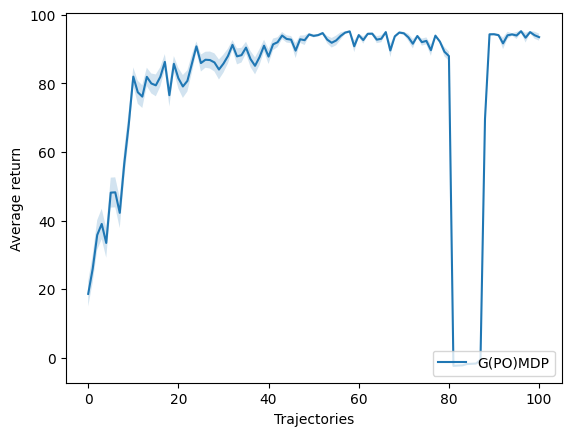

In [11]:
plot_results(results)# learning curve (avg reward). Slowly reduce the lr -> smoother